# Analyzing the Impact of Enterprise Characteristics on the Use of Mobile                         Money Wage Payments in Kenya: A Machine Learning Approach

## Research Questions and Objectives

The purpose of this research is to investigate the impact of enterprise characteristics on the adoption of mobile money wage payments in Kenya. To achieve this aim, the following research questions and objectives will guide the study:

- What is the current state of mobile money wage payments adoption in Kenya, and what factors have influenced it?
	
- How does the size of enterprises influence the adoption of mobile money wage payments in Kenya, and what are the implications of these findings for policymakers and firms? 
	
- How does the level of digitalization on internal processes of enterprises influence the adoption of mobile money wage payments in Kenya, and what are the implications of these findings for policymakers and firms?
	
- How does the Business sector of enterprises influence the adoption of mobile money wage payments in Kenya, and what are the implications of these findings for policymakers and firms?
	

This study seeks to shed light on how policymakers and businesses can utilize these factors to encourage the uptake of mobile money in the country. The study will focus specifically on enterprises in Kenya that have taken part in the World Bank Enterprise Surveys.

## Neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from scipy.stats import uniform as uniform
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
plt.style.use('fivethirtyeight')
#sns.set_palette("colorblind")
#sns.set_style('whitegrid')
import random
np.random.seed(123)  

/home/dhorasso/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


# I- Data Processing

Before analyzing the data, it is essential to perform some feature engineering to enhance the quality and relevance of our analysis. Feature engineering involves transforming, creating, or selecting meaningful variables that can improve the accuracy and effectiveness of our models. 

In [2]:

def Read_and_clean(name_file):
    """
    -------------------------------
    Description of the variables
    ------------------------------
    a6b: enterprise size,
       c3 : electricity connection,
       c10: have generator,
       c22b: internet connection,
       d1a1a: enterprise sector,
       d2: turnover,
       MMs3: paid employees using MM,
       MMs5: paid suppliers using MM,
       MMs7: paid utility bills by MM
       MMs9: Customer's paid by MM
       e1: buisness area,
       k6: have a bank account
    """
    df = pd.read_stata(name_file)
    df = df[["a3a","a6b","b7","b7a","c3","c10","c22b","d1a1a","d2", "MMs1","MMs2","MMs3","MMs5","MMs7","MMs11","MMs12","MMs9","e1","k6"]]

    # If we don't have transaction by MM we don't have payment by MM
    df.loc[df["MMs1"] == "No", ["MMs3","MMs5","MMs9","MMs7","MMs12"]] = "No"
    #df.loc[df["c10"] == "Yes", "c3"] = "Yes"
    #df.loc[df["MMs5"] == "Yes", "MMs3"] = "Yes"

    # Replace numerical values in column "d2" with a categorical variable
    df['d2'] = pd.to_numeric(df['d2'], errors='coerce')
    # Define the bins and labels for the categorical variable
    bins = [0, 5e5, 5e7, 1e9,float('inf')]
    labels = ['500 000 <', '500 000 - 50 million', '50 millions - 1 bilion', '< 1 billion ']
    #Create the categorical variable
    df['d2'] = pd.cut(df['d2'], bins=bins, labels=labels, include_lowest=True)
    
    df['b7'] = pd.to_numeric(df['b7'], errors='coerce')
    # Define the bins and labels for the categorical variable
    bins = [0,20, 40, 60, float('inf')]
    labels = ['20 <', '20 - 40', '40 - 60', '60>']
    #Create the categorical variable
    df['b7'] = pd.cut(df['b7'], bins=bins, labels=labels, include_lowest=True)


    # merge c3 and c10
    c310=[]
    for index , row in df.iterrows () :
        if row ["c3"]=="Yes" or row["c10"]=="Yes":
            c310.append("Yes")         
        else :
            c310.append("No")
    df["c310"]=c310
    
    digitalization_level=[]
    for index , row in df.iterrows () :
        if row ["c310"]=="Yes"  and row["c22b"]=="Yes":
            digitalization_level.append("High")         
        elif row ["c310"]=="No" and row["c22b"]=="No" :
            digitalization_level.append("Low")
        else:
            digitalization_level.append("Medium")
    df["DL"]=digitalization_level
    

    # Rename the value of the column "e1"
    df["e1"].replace({"Local â\x80\x93 main product sold mostly in same municipality where establishment is located": "Local",\
                      "National â\x80\x93 main product sold mostly across the country where establishment is located": "National"}, inplace=True)

    # Compute the frequency of non-missing values in the column 'e1'
    freq = df['e1'].value_counts(normalize=True)

    # List of non-missing values in the column 'e1'
    non_missing = df['e1'].dropna().unique()

    # Replace missing values with non-missing values randomly while respecting their frequency of occurrence.
    df.loc[df['e1'].isna(), 'e1'] = np.random.choice(non_missing, size=df['e1'].isna().sum(), p=freq.values)

    df = df[["a6b","b7","b7a","DL","d1a1a","d2","MMs3","MMs5","MMs7","MMs9","MMs12","e1","k6"]]
    df.replace("Don't know (spontaneous)", np.nan, inplace=True)
    return df

### dataset Kenya 2018 : Categorical dataset

Visualization of the dataset

In [23]:
df=Read_and_clean('Kenya-2018-full-data.dta')
df

,a6b,b7,b7a,DL,d1a1a,d2,MMs3,MMs5,MMs7,MMs9,MMs12,e1,k6
0,Small,20 - 40,No,Medium,Retail trade of,500 000 - 50 million,No,No,No,No,No,Local,No
1,Small,20 <,No,Low,Manufacturing of,500 000 - 50 million,No,No,No,No,No,International,Yes
2,Small,20 <,No,Medium,Retail trade of,500 000 - 50 million,No,No,No,No,No,International,Yes
3,Small,20 <,No,Medium,Manufacturing of,500 000 - 50 million,No,No,No,No,No,Local,No
4,Medium,20 <,No,Low,Manufacturing of,50 millions - 1 bilion,No,No,No,No,No,National,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Medium,20 <,No,High,Manufacturing of,50 millions - 1 bilion,No,No,Yes,Yes,No,National,Yes
997,Large,20 <,No,High,Manufacturing of,NaN,No,No,No,No,No,National,Yes
998,Medium,20 - 40,No,Medium,Wholesale trade of,50 millions - 1 bilion,No,No,No,Yes,No,International,Yes
999,Medium,20 - 40,No,High,Manufacturing of,50 millions - 1 bilion,No,No,No,No,No,National,Yes


### Note !!!: THE TARGET VARIABLE IS MMs3

#### Save as a csv

In [ ]:
df.to_csv('Data_clean.csv', index=False) 
pd.read_csv('Data_clean.csv')

# II- Descriptive Data Analysis
This section presents the results on a descriptive analysis on a factors affecting the use mobile payments adoption the Kenya enterprises. Mobile payment adoption is measured by analysing the percentage of enterprises that use mobile payments to pay their employees.


## I.1- Level of adoption of MM for wage

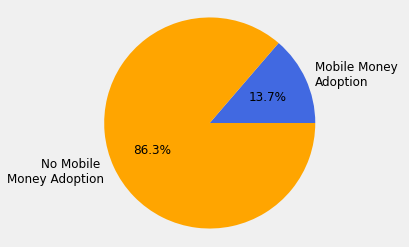

In [24]:
# select the column with mobile payment adoption data
mm_df = df[['MMs3']]

# group the data by MMs3 and count the values
mm_counts = mm_df.groupby(['MMs3']).size()

# create a list of colors for the pie chart
colors = ['royalblue', 'orange']

# create the pie chart with smaller font size for labels and title
plt.pie(mm_counts, labels=['Mobile Money \nAdoption', 'No Mobile \nMoney Adoption'], colors=colors, autopct='%1.1f%%', textprops={'fontsize': 12})

plt.axis('equal')

plt.box(on=None)

plt.show()


 According to this result it's clear that we deal with imbalence dataset

## I.2- Analysis of the factors influencing Mobile Payment

### A-***Business Sector***

In [25]:
def sector(df):
    """Target market and adoption of MM to pay the employee"""
    
    grouped = df.groupby("d1a1a").size().reset_index(name="Total")
    yes_counts = df[df["MMs3"] == "Yes"].groupby("d1a1a").size().reset_index(name="M-payment adoption") # count
    result1 = pd.merge(grouped, yes_counts, on="d1a1a", how="left")
    result1["M-payment adoption rate"] = result1["M-payment adoption"] / result1["Total"] * 100 # percentage
    result1 = result1.rename(columns={"d1a1a": "Sector"})
    
    result1 = result1.sort_values(by="M-payment adoption rate", ascending=True) # sort by decreasing order
    colors = [ 'wheat','cadetblue', 'steelblue','gray','slateblue',"olive"]
    fig, ax = plt.subplots(figsize=(8, 5))
    result1.plot(x="Sector", y="M-payment adoption rate", kind="barh", ax=ax, color=colors)
    plt.ylabel("Sector")
    plt.xlabel("M-Payment Adoption Rate (%)")
    ax.set_xlim([0, 55])

    ax.legend().remove()

    # Add percentage labels to the end of each bar
    for i, v in enumerate(result1["M-payment adoption rate"]):
        ax.text(v + 1, i, f"{v:.1f}%", ha="left", fontdict={"fontsize": 10})
        
    return result1


,Sector,Total,M-payment adoption,M-payment adoption rate
2,Wholesale trade of,56,4,7.142857
0,Manufacturing of,455,49,10.769231
4,Hotel or restaurant,149,17,11.409396
1,Retail trade of,219,26,11.872146
5,Provide services of,74,17,22.972973
3,Construction of,48,24,50.000000


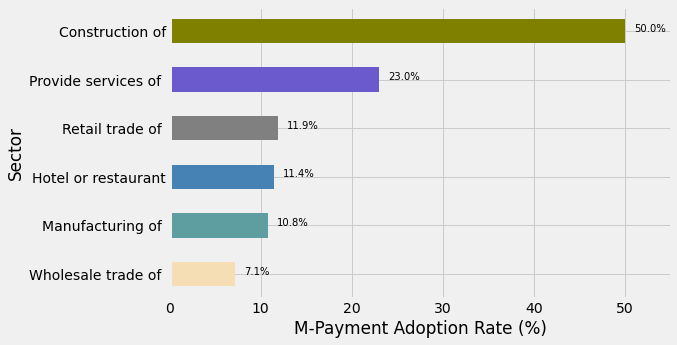

In [26]:
sector(df)

### B-***Main market***

In [27]:
def zone(df):
    """Market area and adoption of MM to paid the employee"""

    grouped = df.groupby("e1").size().reset_index(name="Total")
    yes_counts = df[df["MMs3"] == "Yes"].groupby("e1").size().reset_index(name="M-payement adoption")
    result1 = pd.merge(grouped, yes_counts, on="e1", how="left")
    result1["M-payment adoption rate"] = result1["M-payement adoption"] / result1["Total"] * 100 # percentage
    result1 = result1.rename(columns={"e1": "Market zone"})
    colors = [ 'cadetblue', 'steelblue','wheat']
    fig, ax = plt.subplots(figsize=(8, 5))
    result1.plot(x="Market zone", y="M-payment adoption rate", kind="bar", ax=ax, color=colors)
   # plt.title("M-Payment Adoption Rate by Market zone")
    plt.xlabel("Competion Level")
    plt.ylabel("M-Payment Adoption Rate (%)")
    plt.xticks(rotation=0)
    ax.set_ylim([0, 20])
    # Add percentage labels to the top of each bar 
    for p in ax.patches:
        height = p.get_height()
        percentage = f"{height:.1f}%"
        ax.text(p.get_x() + p.get_width() / 2, height + 1, percentage, ha="center", fontdict={ "fontsize": 10})
    ax.legend().remove()
    plt.show()
    return result1

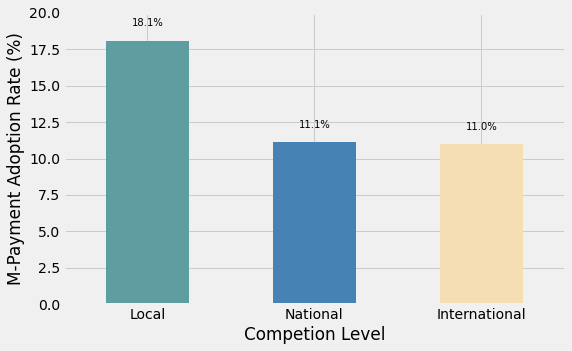

,Market zone,Total,M-payement adoption,M-payment adoption rate
0,Local,376,68,18.085106
1,National,297,33,11.111111
2,International,328,36,10.975610


In [28]:
zone(df)

<AxesSubplot:xlabel='e1', ylabel='M-payment adoption rate'>

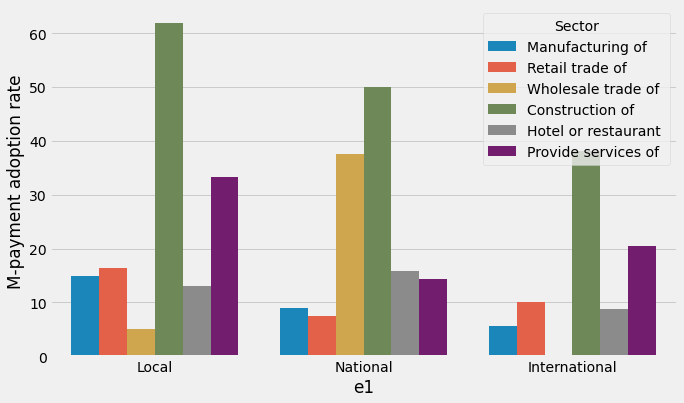

In [29]:
grouped = df.groupby(['d1a1a', 'e1']).size().reset_index(name="Total")
yes_counts = df[df["MMs3"] == "Yes"].groupby(['d1a1a', 'e1']).size().reset_index(name="M-payment adoption") # count
result1 = pd.merge(grouped, yes_counts, how="left")
result1["M-payment adoption rate"] = result1["M-payment adoption"] / result1["Total"] * 100 # percentage
result1=result1.rename(columns={'d1a1a':'Sector'})


plt.figure(figsize=(10,6))
sns.barplot(x='e1', y='M-payment adoption rate', hue='Sector', data=result1)

### C-***Bank Account***

In [30]:
def BA(df):
    """Bank Account and adoption of MM to paid the employee"""
    
    grouped = df.groupby("k6").size().reset_index(name="Total")
    yes_counts = df[df["MMs3"] == "Yes"].groupby("k6").size().reset_index(name="M-payement adoption")
    result1 = pd.merge(grouped, yes_counts, on="k6", how="left")
    result1["M-payment adoption rate"] = result1["M-payement adoption"] / result1["Total"] * 100 # percentage
    result1 = result1.rename(columns={"k6": "saving Account"})
    
    fig, ax = plt.subplots(figsize=(6, 4))
    result1.plot(x="saving Account", y="M-payment adoption rate", kind="bar", ax=ax)
    plt.xlabel("Bank Account")
    plt.ylabel("M-Payment Adoption Rate (%)")
    ax.set_ylim([0, 20])
    for p in ax.patches:
        height = p.get_height()
        percentage = f"{height:.1f}%"
        ax.text(p.get_x() + p.get_width() / 2, height + 1, percentage, ha="center", fontdict={ "fontsize": 10})
    ax.legend().remove()
    plt.show()
    return result1

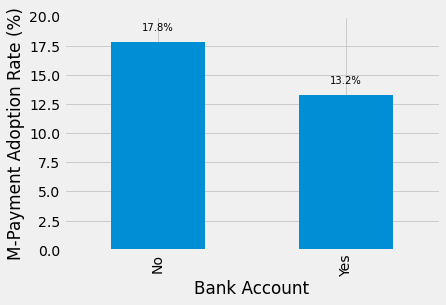

,saving Account,Total,M-payement adoption,M-payment adoption rate
0,No,90,16,17.777778
1,Yes,906,120,13.245033


In [31]:
BA(df)

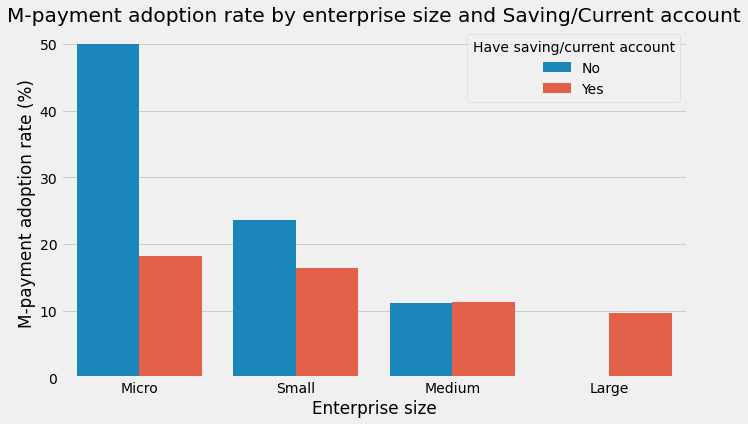

In [32]:

grouped = df.groupby(['a6b', 'k6']).size().reset_index(name="Total")
yes_counts = df[df["MMs3"] == "Yes"].groupby(['a6b', 'k6']).size().reset_index(name="M-payement adoption") # count
result1 = pd.merge(grouped, yes_counts, how="left")
result1["M-payment adoption rate"] = result1["M-payement adoption"] / result1["Total"] * 100 # percentage
result1.replace(np.nan,0)
result1=result1.rename(columns={'k6': 'Have saving/current account'})


plt.figure(figsize=(10,6))
sns.barplot(x='a6b', y='M-payment adoption rate', hue='Have saving/current account', data=result1)
# set the title and axes labels
plt.title('M-payment adoption rate by enterprise size and Saving/Current account')
plt.xlabel('a6b')
plt.ylabel('M-payment adoption rate (%)')
#plt.legend(loc='upper left')
plt.xlabel("Enterprise size")
plt.show()

### D-***Enterprise size***

In [33]:
def size(df):
    """Size of enterprise and adoption of MM to paid the employee"""

    grouped = df.groupby("a6b").size().reset_index(name="Total")
    yes_counts = df[df["MMs3"] == "Yes"].groupby("a6b").size().reset_index(name="M-payement adoption")
    result2 = pd.merge(grouped, yes_counts, on="a6b", how="left")
    result2["M-payment adoption rate"] = result2["M-payement adoption"] / result2["Total"] * 100
    result2 = result2.rename(columns={"a6b": "Size"})

    fig, ax = plt.subplots(figsize=(8, 4))

    colors = ['#1f77b4', '#9467bd', '#8c564b', '#7f7f7f', '#bcbd22']
    result2.plot(x="Size", y="M-payment adoption rate", kind="bar", ax=ax, color=colors)
    plt.ylabel("M-Payment Adoption Rate (%)")
    plt.xlabel("Enterprise size")
    plt.xticks(rotation=0)

    ax.set_ylim([0, 30])
    for p in ax.patches:
        height = p.get_height()
        percentage = f"{height:.1f}%"
        ax.text(p.get_x() + p.get_width() / 2, height + 1, percentage, ha="center", fontdict={ "fontsize": 10})
    ax.legend().remove()

    plt.show()

    return result2
 #'#ff7f0e', '#2ca02c', '#d62728',

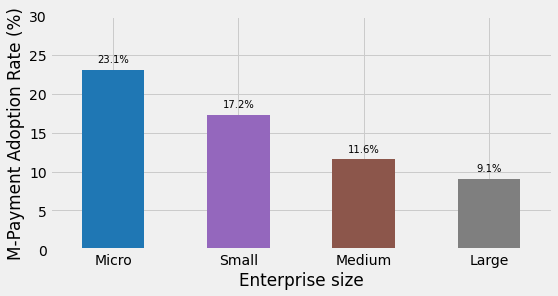

,Size,Total,M-payement adoption,M-payment adoption rate
0,Micro,13,3,23.076923
1,Small,429,74,17.249417
2,Medium,372,43,11.559140
3,Large,187,17,9.090909


In [34]:
size(df)

In [35]:
def Turnover(df):
    """ Turnover and adoption of MM to pay the employee"""
    
    grouped = df.groupby("d2").size().reset_index(name="Total")
    yes_counts = df[df["MMs3"] == "Yes"].groupby("d2").size().reset_index(name="M-payement adoption")
    result2 = pd.merge(grouped, yes_counts, on="d2", how="left")
    result2["M-payment adoption rate"] = result2["M-payement adoption"] / result2["Total"] * 100
    result2 = result2.sort_values(by="M-payment adoption rate", ascending=True) # sort by decreasing order
    
    # Define a list of colors
    colors = [ 'khaki','cadetblue', 'steelblue','gray']
    
    fig, ax = plt.subplots(figsize=(8, 4))
    result2.plot(x="d2", y="M-payment adoption rate", kind="barh", ax=ax, color=colors)
    plt.ylabel("Turnover")
    plt.xlabel("M-Payment Adoption Rate (%)")
    ax.set_xlim([0, 30])

    ax.legend().remove()

    for i, v in enumerate(result2["M-payment adoption rate"]):
        ax.text(v + 1, i - 0.1, str(round(v, 1)) + "%", color='black', fontsize=10)
        
    return result2


,d2,Total,M-payement adoption,M-payment adoption rate
3,< 1 billion,57,4,7.017544
2,50 millions - 1 bilion,347,41,11.815562
1,500 000 - 50 million,470,73,15.531915
0,500 000 <,20,5,25.000000


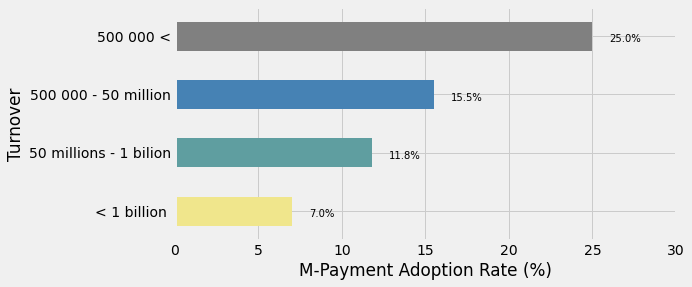

In [36]:
Turnover(df)

In [37]:
def size_bank(df):
    """ Turnover and adoption of MM to pay the employee"""
    
    grouped = df.groupby("a6b").size().reset_index(name="Total")
    yes_counts = df[df["k6"] == "Yes"].groupby("a6b").size().reset_index(name="Enterprise having BA")
    result2 = pd.merge(grouped, yes_counts, on="a6b", how="left")
    result2["Rate of enterprise having BA"] = result2["Enterprise having BA"] / result2["Total"] * 100
    fig, ax = plt.subplots(figsize=(8, 4))
    result2.plot(x="a6b", y="Rate of enterprise having BA", kind="bar", ax=ax)
    plt.ylabel("Rate of enterprise having BA(%)")
    plt.xlabel("")
    
    ax.set_ylim([0, 110])
    for p in ax.patches:
        height = p.get_height()
        percentage = f"{height:.1f}%"
        ax.text(p.get_x() + p.get_width() / 2, height + 1, percentage, ha="center", fontdict={ "fontsize": 10})
    ax.legend().remove()
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return result2


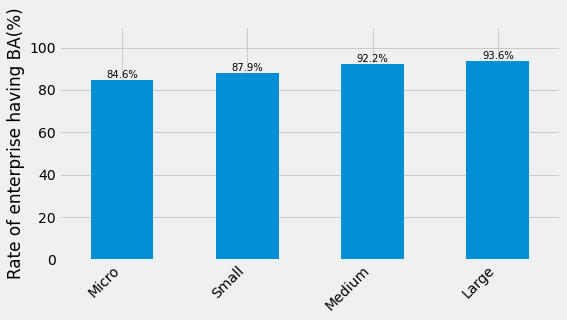

,a6b,Total,Enterprise having BA,Rate of enterprise having BA
0,Micro,13,11,84.615385
1,Small,429,377,87.878788
2,Medium,372,343,92.204301
3,Large,187,175,93.582888


In [38]:
size_bank(df)

### E-*** Digitalization Level***

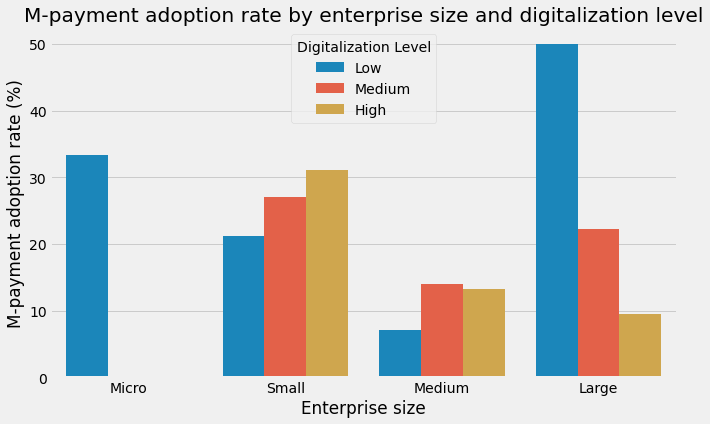

In [39]:
grouped = df.groupby(['a6b', 'DL']).size().reset_index(name="Tot")
yes_counts = df[df["MMs3"] == "Yes"].groupby(['a6b', 'DL']).size().reset_index(name="Mpa") # count
result1 = pd.merge(grouped, yes_counts, how="left")
result1["M-payment adoption"]=[2, 0, 0 , 18, 27, 14, 1, 11, 14, 1, 4, 7]
result1['Digitalization Level']=["Low", "Medium", "High","Low", "Medium", "High","Low", "Medium", "High","Low", "Medium", "High"]
result1['Total']= [6, 0, 0, 85, 100, 45, 14, 79, 106, 2, 18, 74]
result1["M-payment adoption rate"] = result1["M-payment adoption"] / result1["Total"] * 100 # percentage
result1.replace(np.nan,0)


plt.figure(figsize=(10,6))
sns.barplot(x='a6b', y='M-payment adoption rate', hue='Digitalization Level', data=result1)
#plt.ylim([0,60])
# set the title and axes labels
plt.title('M-payment adoption rate by enterprise size and digitalization level')
#plt.xlabel('a6b')
plt.ylabel('M-payment adoption rate (%)')
#plt.legend(loc='upper left')
plt.xlabel("Enterprise size")
plt.show()

## Cronbach's Alpha


To ensure the reliability of the data, we use the Cronbach's Alpha coefficient ($\alpha$) to measure the internal consistency of the data. Which is the degree to which a variable consistently measures what it is intended to measure and yields stable results over time. Cronbach's Alpha calculates the extent to which items in a scale or questionnaire measure the same underlying construct or concept. It measures the average correlation between all possible pairs of scale items, which indicates the extent to which items are related to each other.

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from factor_analyzer import FactorAnalyzer


# Convert categorical variables to numerical labels
le = LabelEncoder()
df = df.apply(le.fit_transform)

# Compute Cronbach's alpha for each column
# Compute Cronbach's alpha and chi-square test for each column
alpha_scores = []
for column in df.columns:
    items = df[column]
    num_items = len(items)
    variance = items.var()
    total_variance = df.sum(axis=1).var()
    alpha = (num_items / (num_items - 1)) * (1 - (variance / total_variance))
    alpha_scores.append(alpha)


# Create a dataframe to store the results
results_df = pd.DataFrame({
    "Column": df.columns,
    "Cronbach's Alpha": alpha_scores
})

# Display the results
results_df


,Column,Cronbach's Alpha
0,a6b,0.846302
1,b7,0.946904
2,b7a,0.986723
3,DL,0.915278
4,d1a1a,0.829498
5,d2,0.835864
6,MMs3,0.988372
7,MMs5,0.979895
8,MMs7,0.977599
9,MMs9,0.975169



The Table \ref{tab1} displays that the Cronbach alpha coefficients for all the variables exceeded the recommended threshold of $0.7$, which has been suggested by various researchers \citep{davis1989perceived, peterson1994meta}. Based on the findings of this study, we are confident in stating that the measurement items possess strong internal consistency.